In [1]:
#change to data location

In [2]:
#mandatory imports

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
import math
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
import seaborn as sns
from time import time

#### 3. Load and pre-process the dataset if necessary. Explain steps that you have taken. Are there any alternative ways for doing that? Explain.

In [3]:
df_customer = pd.read_csv("Customer relationship marketing (CRM).csv")
#checking for null and duplicates
print (df_customer[df_customer.isnull().any(axis=1)].shape) #null check
print(df_customer.shape)
df_customer.drop_duplicates()
print(df_customer.shape)
print (df_customer.dtypes)

(0, 20)
(9134, 20)
(9134, 20)
State                         object
Customer Lifetime Value      float64
Response                      object
Coverage                      object
Education                     object
Effective To Date             object
EmploymentStatus              object
Gender                        object
Income                         int64
Location Code                 object
Marital Status                object
Monthly Premium Auto           int64
Months Since Last Claim        int64
Number of Open Complaints      int64
Number of Policies             int64
Policy                        object
Renew Offer Type              object
Sales Channel                 object
Total Claim Amount           float64
Vehicle Class                 object
dtype: object


In [4]:
#label encoding of target variable
le = preprocessing.LabelEncoder()
le.fit(df_customer["Response"])
le.classes_
df_customer["Response"] = le.transform(df_customer["Response"])
original_labels = list(le.inverse_transform([0,1]))
print("Original Lables", original_labels)


Original Lables ['No', 'Yes']


In [5]:
#one hot encoding of categorical variables
df_customer["Date_temp"] = (pd.to_datetime(df_customer["Effective To Date"]))
df_customer["DayOfMonth"] = df_customer["Date_temp"].apply(lambda x: x.day)
df_customer["Month"] = df_customer["Date_temp"].apply(lambda x: x.month)
df_customer["WeekDay"] = df_customer["Date_temp"].apply(lambda x: x.weekday())
df_customer["Year"] = df_customer["Date_temp"].apply(lambda x: x.year)
df_customer["DayCount"] = df_customer["Date_temp"].apply(lambda x: x.toordinal())
df_customer["DayOfYear"] = df_customer["Date_temp"].apply(lambda x: x.timetuple().tm_yday)

df_customer.drop(["Effective To Date", "Date_temp"], axis=1, inplace = True)


In [6]:
df_customer_encoded = df_customer.copy()
df_customer_categorical = df_customer_encoded.select_dtypes(include='object')
encoded_df = pd.get_dummies(df_customer_categorical)
df_customer_encoded = df_customer_encoded.drop(df_customer_categorical, axis=1)
df_customer_encoded = pd.concat([df_customer_encoded, encoded_df], axis=1)

In [7]:
#X, Y = df_customer.loc[:, df_customer.columns != 'Response'], df_customer["Response"]
#x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=42)

X_enc, Y_enc = df_customer_encoded.loc[:, df_customer_encoded.columns != 'Response'], df_customer_encoded["Response"]
x_train_enc, x_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, Y_enc, stratify=Y_enc, test_size=0.3, random_state=42)

In [8]:
(unique, counts) = np.unique(y_train_enc, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print ("Frequencies:", frequencies)
print ("Imbalance ratio: after split", frequencies[0][1]/frequencies[1][1])
print ("Imbalance ratio before split: ", \
       df_customer.loc[df_customer['Response'] == 0].Response.count()/ df_customer.loc[df_customer['Response'] == 1].Response.count())


Frequencies: [[   0 5478]
 [   1  915]]
Imbalance ratio: after split 5.9868852459016395
Imbalance ratio before split:  5.983180428134556


#### 4. Analyse the importance of the features for predicting customer response using two different approaches. Explain the similarity/difference between outcomes.

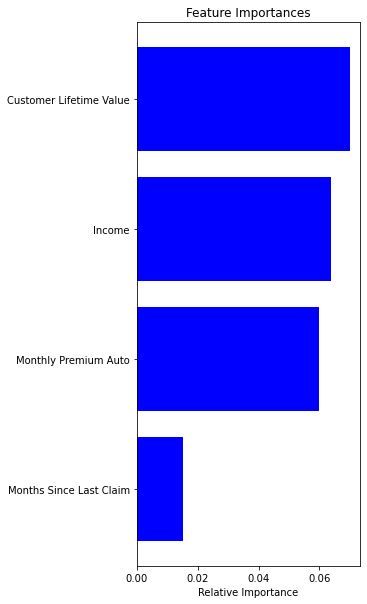

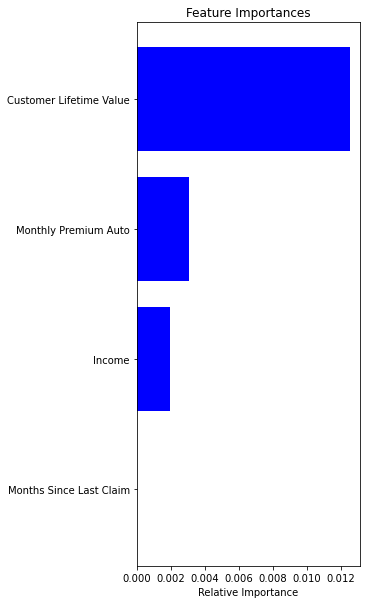

In [9]:
#feature importance based on impurity
clf = RandomForestClassifier(max_depth=25, random_state=42)
clf = clf.fit(X_enc,Y_enc)

features = list(X_enc.columns)
feature_imp = clf.feature_importances_

feature_imp = feature_imp[1:5]
indices = np.argsort(feature_imp)

plt.figure(1, figsize=(4, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#feature importance based on permutation
result = permutation_importance(clf, X_enc, Y_enc, n_repeats=3, random_state=42, n_jobs=4)
feature_imp = pd.Series(result.importances_mean, index=list(X_enc.columns))
feature_imp = feature_imp[1:5]
indices = np.argsort(feature_imp)

plt.figure(1, figsize=(4, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### 5. Create three supervised machine learning (ML) models except any ensemble approach for predicting customer response.<br>
a. Report performance score using a suitable metric. Is it possible that the presented result is an overfitted one? Justify.<br>
b. Justify different design decisions for each ML model used to answer this question.<br>
c. Have you optimised any hyper-parameters for each ML model? What are they? Why have you done that? Explain.<br>
d. Finally, make a recommendation based on the reported results and justify it.<br>

Time taken SVM rbf:  0.07442539219263043
1.0
[0.99843628 0.99296325 0.99843628 0.99843505 0.99608764]
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      2348
         Yes       1.00      1.00      1.00       393

    accuracy                           1.00      2741
   macro avg       1.00      1.00      1.00      2741
weighted avg       1.00      1.00      1.00      2741



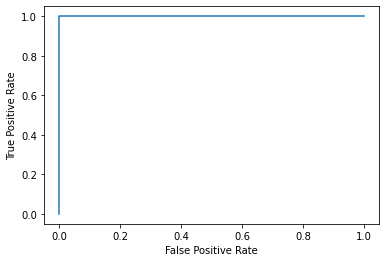

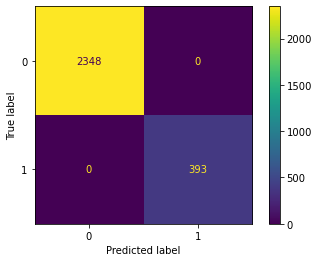

In [10]:
#Model 1a: SVM rbf
clf = svm.SVC(kernel='rbf', C=100, random_state=42, max_iter=230, gamma=0.1)
clf.fit(x_train_enc, y_train_enc)
milliseconds_a = int(time() * 1000)
y_pred = clf.predict(x_test_enc)
milliseconds_b = int(time() * 1000)
dif = milliseconds_b - milliseconds_a
avg_time = dif / len(x_test_enc)
print ("Time taken SVM rbf: ", avg_time)
print(accuracy_score(y_test_enc, y_pred))

cv = StratifiedKFold(5, shuffle=True, random_state=0)
scores = cross_val_score(clf, x_train_enc, y_train_enc, cv=cv)
print (scores)

y_score = []
if hasattr(clf, "decision_function"):
    y_score = clf.decision_function(x_test_enc)
else:
    y_score = clf.predict_proba(x_test_enc)[:, 1]
    
fpr, tpr, _ = roc_curve(y_test_enc, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print (classification_report(y_test_enc, y_pred, target_names=original_labels))

cm = confusion_matrix(y_test_enc, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Time taken SVM linear:  0.0018241517694272164
0.8744983582634075
[0.86942924 0.87177482 0.87255668 0.87245696 0.87089202]
              precision    recall  f1-score   support

          No       0.88      0.99      0.93      2348
         Yes       0.79      0.17      0.28       393

    accuracy                           0.87      2741
   macro avg       0.83      0.58      0.61      2741
weighted avg       0.86      0.87      0.84      2741



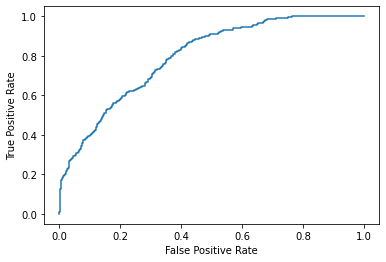

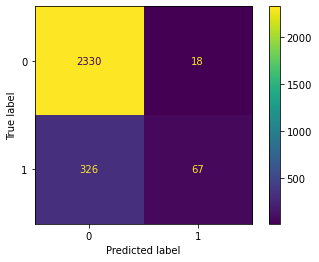

In [11]:
#Model 1b: svm linear
#dual = False because num_features < num_samples
clf = make_pipeline(StandardScaler(), svm.LinearSVC(C = 5.0, random_state=42, tol=1e-5, max_iter=5000, dual=False))

clf.fit(x_train_enc, y_train_enc)
milliseconds_a = int(time() * 1000)
y_pred = clf.predict(x_test_enc)
milliseconds_b = int(time() * 1000)
dif = milliseconds_b - milliseconds_a
avg_time = dif / len(x_test_enc)
print ("Time taken SVM linear: ", avg_time)

print(accuracy_score(y_test_enc, y_pred))
cv = StratifiedKFold(5, shuffle=True, random_state=0)
scores = cross_val_score(clf, x_train_enc, y_train_enc, cv=cv)
print (scores)


y_score = []
if hasattr(clf, "decision_function"):
    y_score = clf.decision_function(x_test_enc)
else:
    y_score = clf.predict_proba(x_test_enc)[:, 1]
    
fpr, tpr, _ = roc_curve(y_test_enc, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print (classification_report(y_test_enc, y_pred, target_names=original_labels))

cm = confusion_matrix(y_test_enc, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

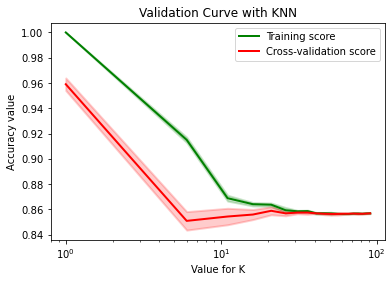

In [12]:
#Model 2 KNN

#Check for best K
param_range = np.arange(1, math.sqrt(df_customer["Response"].count()), 5, dtype = int)

train_scores, test_scores = validation_curve(
    KNeighborsClassifier(), x_train_enc, y_train_enc, param_name="n_neighbors", param_range=param_range,
    scoring="accuracy", n_jobs=4)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with KNN")
plt.xlabel("Value for K")
plt.ylabel("Accuracy value")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="green", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="green", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="red", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="red", lw=lw)
plt.legend()
plt.show()

Time taken KNN:  0.1298796059832178
0.9704487413352791
[0.95230649 0.94370602 0.95856138 0.9514867  0.94679186]
0.950570489219742
              precision    recall  f1-score   support

          No       1.00      0.97      0.98      2348
         Yes       0.84      0.99      0.91       393

    accuracy                           0.97      2741
   macro avg       0.92      0.98      0.94      2741
weighted avg       0.97      0.97      0.97      2741



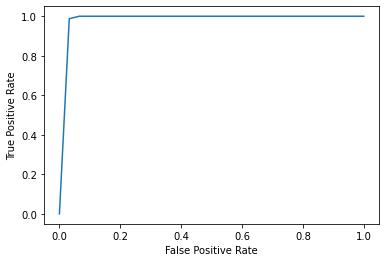

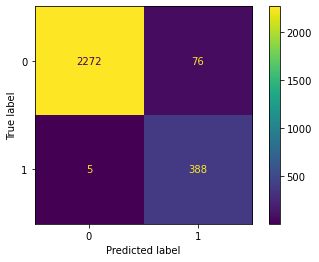

In [13]:
#predict using best K
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(x_train_enc, y_train_enc)

#test on test set
milliseconds_a = int(time() * 1000)
y_pred = clf.predict(x_test_enc)
milliseconds_b = int(time() * 1000)
dif = milliseconds_b - milliseconds_a
avg_time = dif / len(x_test_enc)
print ("Time taken KNN: ", avg_time)
print(accuracy_score(y_test_enc, y_pred))

#StratifiedKFold cross validate
cv = StratifiedKFold(5, shuffle=True, random_state=0)
scores = cross_val_score(clf, x_train_enc, y_train_enc, cv=cv)
print (scores)
print (scores.mean())

y_score = []
if hasattr(clf, "decision_function"):
    y_score = clf.decision_function(x_test_enc)
else:
    y_score = clf.predict_proba(x_test_enc)[:, 1]
    
fpr, tpr, _ = roc_curve(y_test_enc, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print (classification_report(y_test_enc, y_pred, target_names=original_labels))

cm = confusion_matrix(y_test_enc, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

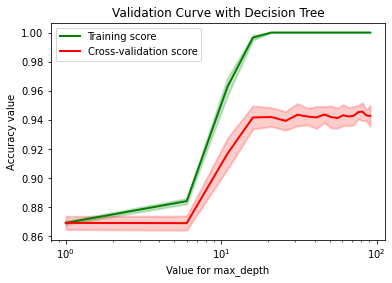

In [14]:
#Model 3: Decision Tree Classifier
#Check for best max depth
param_range = np.arange(1, math.sqrt(df_customer["Response"].count()), 5, dtype = int)

train_scores, test_scores = validation_curve(
    tree.DecisionTreeClassifier(), x_train_enc, y_train_enc, param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=4)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Decision Tree")
plt.xlabel("Value for max_depth")
plt.ylabel("Accuracy value")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="green", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="green", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="red", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="red", lw=lw)
plt.legend()
plt.show()

Time taken Decision Tree:  0.001459321415541773
0.9693542502736228
[0.95777952 0.94448788 0.94839719 0.95070423 0.94131455]
0.9693542502736228
              precision    recall  f1-score   support

          No       1.00      0.97      0.98      2348
         Yes       0.84      0.98      0.90       393

    accuracy                           0.97      2741
   macro avg       0.92      0.97      0.94      2741
weighted avg       0.97      0.97      0.97      2741



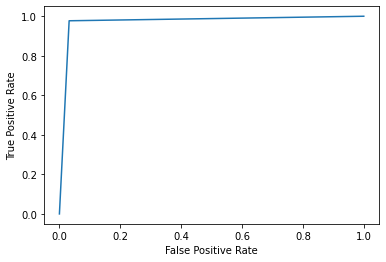

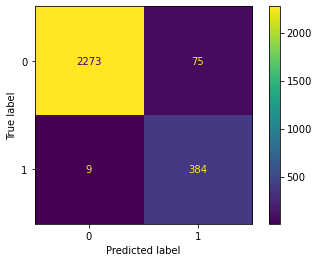

In [15]:
#predict on testset
#StratifiedKFold cross validate on train set
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = 20, random_state=42)
clf = clf.fit(x_train_enc, y_train_enc)

milliseconds_a = int(time() * 1000)
y_pred = clf.predict(x_test_enc)
milliseconds_b = int(time() * 1000)
dif = milliseconds_b - milliseconds_a
avg_time = dif / len(x_test_enc)
print ("Time taken Decision Tree: ", avg_time)

print(accuracy_score(y_test_enc, y_pred))
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(clf, x_train_enc, y_train_enc, cv=cv)
print (scores)
mean_score = clf.score(x_test_enc, y_test_enc, sample_weight=None)
print (mean_score)

y_score = []
if hasattr(clf, "decision_function"):
    y_score = clf.decision_function(x_test_enc)
else:
    y_score = clf.predict_proba(x_test_enc)[:, 1]
    
fpr, tpr, _ = roc_curve(y_test_enc, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print (classification_report(y_test_enc, y_pred, target_names=original_labels))

cm = confusion_matrix(y_test_enc, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

#### 6. Build three ensemble models for predicting customer response. <br>
a. When do you want to use ensemble models over other ML models?<br>
b. What are the similarities or differences between these models?<br>
c. Is there any preferable scenario for using any specific model among set of ensemble models?<br>
d. Write a report comparing performances of models built in question 5 and 6. Report the best method based on model complexity and performance.<br>
e. Is it possible to build ensemble model using ML classifiers other than decision tree? If yes, then explain with an example.<br>

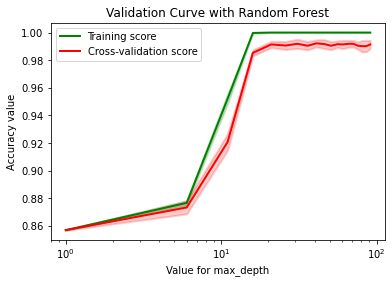

In [16]:
#Ensemble model 1: Random forest
#Check for best max depth

param_range = np.arange(1, math.sqrt(df_customer["Response"].count()), 5, dtype = int)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(), x_train_enc, y_train_enc, param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=4)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Random Forest")
plt.xlabel("Value for max_depth")
plt.ylabel("Accuracy value")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="green", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="green", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="red", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="red", lw=lw)
plt.legend()
plt.show()

Time taken Random Forest:  0.016052535570959505
0.9978110178766874
[0.98983581 0.98592651 0.99374511 0.98982786 0.98669797]
0.9892066498548233
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      2348
         Yes       1.00      0.99      0.99       393

    accuracy                           1.00      2741
   macro avg       1.00      0.99      1.00      2741
weighted avg       1.00      1.00      1.00      2741



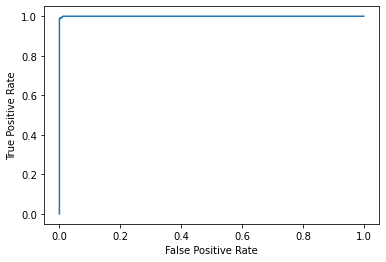

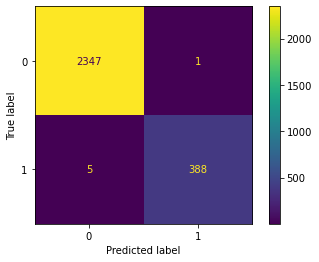

In [17]:
#predict on testset
#StratifiedKFold cross validate on train set
clf = RandomForestClassifier(max_depth=25, random_state=42)
clf = clf.fit(x_train_enc, y_train_enc)

milliseconds_a = int(time() * 1000)
y_pred = clf.predict(x_test_enc)
milliseconds_b = int(time() * 1000)
dif = milliseconds_b - milliseconds_a
avg_time = dif / len(x_test_enc)
print ("Time taken Random Forest: ", avg_time)
print(accuracy_score(y_test_enc, y_pred))

cv = StratifiedKFold(5, shuffle=True, random_state=0)
scores = cross_val_score(clf, x_train_enc, y_train_enc, cv=cv)

print (scores)
print (scores.mean())

y_score = []
if hasattr(clf, "decision_function"):
    y_score = clf.decision_function(x_test_enc)
else:
    y_score = clf.predict_proba(x_test_enc)[:, 1]
    
fpr, tpr, _ = roc_curve(y_test_enc, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print (classification_report(y_test_enc, y_pred, target_names=original_labels))

cm = confusion_matrix(y_test_enc, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

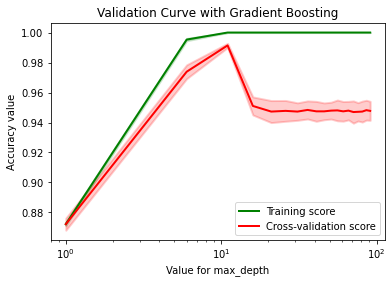

In [18]:
#Ensemble model 2: Gradient Boosting
#check for optimum max_depth
param_range = np.arange(1, math.sqrt(df_customer["Response"].count()), 5, dtype = int)

train_scores, test_scores = validation_curve(
    GradientBoostingClassifier(), x_train_enc, y_train_enc, param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=4)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Gradient Boosting")
plt.xlabel("Value for max_depth")
plt.ylabel("Accuracy value")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="green", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="green", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="red", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="red", lw=lw)
plt.legend()
plt.show()

Time taken Gradient Boost:  0.009850419554906968
0.9970813571689164
[0.99452697 0.99374511 0.99139953 0.98982786 0.98356808]
0.9906135099188651
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      2348
         Yes       0.99      0.99      0.99       393

    accuracy                           1.00      2741
   macro avg       0.99      1.00      0.99      2741
weighted avg       1.00      1.00      1.00      2741



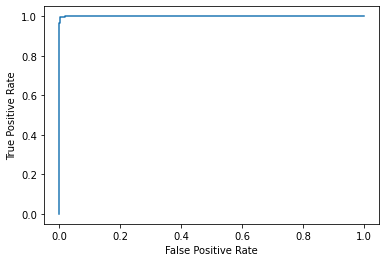

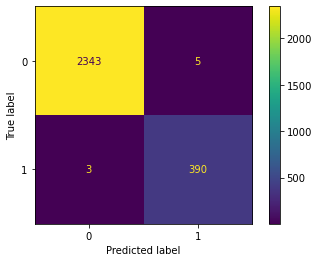

In [19]:
#predict on testset
#StratifiedKFold cross validate on train set
clf = GradientBoostingClassifier(max_depth=12, random_state=42).fit(x_train_enc, y_train_enc)

milliseconds_a = int(time() * 1000)
y_pred = clf.predict(x_test_enc)
milliseconds_b = int(time() * 1000)
dif = milliseconds_b - milliseconds_a
avg_time = dif / len(x_test_enc)
print ("Time taken Gradient Boost: ", avg_time)
cm = confusion_matrix(y_test_enc, y_pred)
print(accuracy_score(y_test_enc, y_pred))

cv = StratifiedKFold(5, shuffle=True, random_state=42)
scores = cross_val_score(clf, x_train_enc, y_train_enc, cv=cv)

print (scores)
print (scores.mean())

y_score = []
if hasattr(clf, "decision_function"):
    y_score = clf.decision_function(x_test_enc)
else:
    y_score = clf.predict_proba(x_test_enc)[:, 1]
    
fpr, tpr, _ = roc_curve(y_test_enc, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

print (classification_report(y_test_enc, y_pred, target_names=original_labels))




cm_display = ConfusionMatrixDisplay(cm).plot()

In [20]:
#Ensembble model 3: Bagging
#Check for optimum number of trees to average

param_range = np.arange(1, 500, 100, dtype = int)

train_scores, test_scores = validation_curve(
    BaggingClassifier(base_estimator= tree.DecisionTreeClassifier()), x_train_enc, y_train_enc, param_name="n_estimators", param_range=param_range,
    scoring="accuracy", n_jobs=4)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

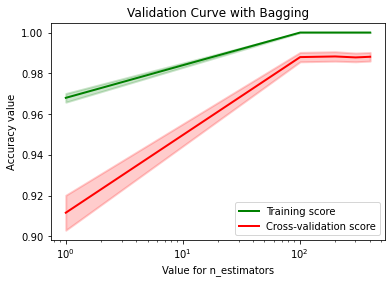

In [21]:
plt.title("Validation Curve with Bagging")
plt.xlabel("Value for n_estimators")
plt.ylabel("Accuracy value")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="green", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="green", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="red", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="red", lw=lw)
plt.legend()
plt.show()

[0.98592651 0.97967162 0.99061767 0.9913928  0.9827856 ]
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      2348
         Yes       0.99      0.99      0.99       393

    accuracy                           1.00      2741
   macro avg       0.99      1.00      0.99      2741
weighted avg       1.00      1.00      1.00      2741

Time taken Bagging:  0.08026267785479752
Accuracy:  0.9927033929222912


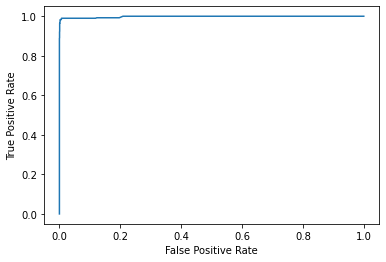

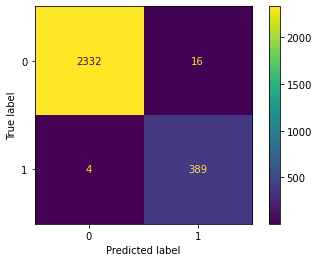

In [22]:
#predict on testset
#StratifiedKFold cross validate on train set
clf = BaggingClassifier(base_estimator= tree.DecisionTreeClassifier(), n_estimators=200, random_state=42)
clf.fit(x_train_enc, y_train_enc)

cv = StratifiedKFold(5, shuffle=True, random_state=0)
scores = cross_val_score(clf, x_train_enc, y_train_enc, cv=cv)

print (scores)

y_score = []
if hasattr(clf, "decision_function"):
    y_score = clf.decision_function(x_test_enc)
else:
    y_score = clf.predict_proba(x_test_enc)[:, 1]
    
fpr, tpr, _ = roc_curve(y_test_enc, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

from sklearn.metrics import classification_report
print (classification_report(y_test_enc, y_pred, target_names=original_labels))

milliseconds_a = int(time() * 1000)
y_pred = clf.predict(x_test_enc)
milliseconds_b = int(time() * 1000)
dif = milliseconds_b - milliseconds_a
avg_time = dif / len(x_test_enc)
print ("Time taken Bagging: ", avg_time)
cm = confusion_matrix(y_test_enc, y_pred)
print("Accuracy: ", accuracy_score(y_test_enc, y_pred))

cm_display = ConfusionMatrixDisplay(cm).plot()

#### e. Is it possible to build ensemble model using ML classifiers other than decision tree? If yes, then explain with an example.

In [23]:
#Ensemble model without tree 1: Bagging using KNN 
from sklearn.svm import SVC
clf = BaggingClassifier(base_estimator=SVC(C = 1.0, random_state=42, tol=1e-5, max_iter=5000), 
                        n_estimators=31, random_state=22)
clf.fit(x_train_enc, y_train_enc)

milliseconds_a = int(time() * 1000)
y_pred = clf.predict(x_test_enc)
milliseconds_b = int(time() * 1000)
dif = milliseconds_b - milliseconds_a
avg_time = dif / len(x_test_enc)
print ("Time taken Bagging: ", avg_time)
cm = confusion_matrix(y_test_enc, y_pred)

Time taken Bagging:  4.580445093031741


              precision    recall  f1-score   support

          No       0.86      1.00      0.92      2348
         Yes       0.00      0.00      0.00       393

    accuracy                           0.86      2741
   macro avg       0.43      0.50      0.46      2741
weighted avg       0.73      0.86      0.79      2741



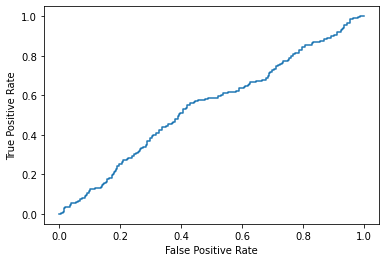

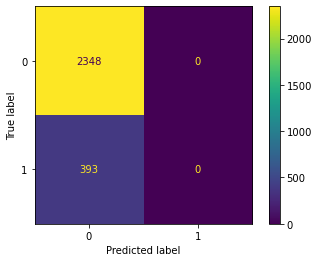

In [24]:
y_score = []
if hasattr(clf, "decision_function"):
    y_score = clf.decision_function(x_test_enc)
else:
    y_score = clf.predict_proba(x_test_enc)[:, 1]
    
fpr, tpr, _ = roc_curve(y_test_enc, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

from sklearn.metrics import classification_report
print (classification_report(y_test_enc, y_pred, target_names=original_labels))
cm_display = ConfusionMatrixDisplay(cm).plot()